In [145]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import cv2
import seaborn
import pandas
from sklearn.metrics import classification_report, confusion_matrix

ModuleNotFoundError: No module named 'cv2'

# Load dataset

In [116]:
PATH = "datasets/Qualite"

In [117]:
batch_size = 32
img_height = 300
img_width = 300
IMG_SIZE = (img_width, img_height)

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
  PATH,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18695 files belonging to 4 classes.
Using 14956 files for training.
Found 18695 files belonging to 4 classes.
Using 3739 files for validation.


In [118]:
# Crée jeu de tests
val_batches = tf.data.experimental.cardinality(validation_ds)
test_dataset = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [119]:
# étiquettes
class_names = ["FaceQual0","FaceQual1","FaceQual2","FaceQual3"]

In [141]:
# affichage
class_names = train_ds.class_names
imgs_take = train_ds.take(1)
imgs = {'img':[], 'label':[]}
for images, labels in imgs_take:
  for i in range(9):
      imgs['img'].append(images[i])
      imgs['label'].append(class_names[labels[i]])

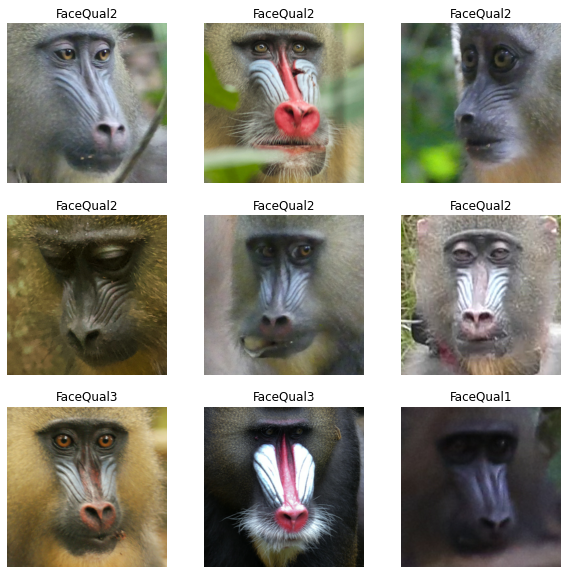

In [142]:
# affichage haute qualité
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(imgs['img'][i].numpy().astype("uint8"))
    plt.title(imgs['label'][i])
    plt.axis("off")

NameError: name 'cv2' is not defined

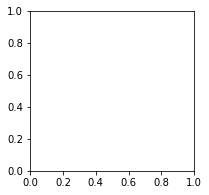

In [144]:
# generating the kernel
x = 11 # flou
y = 50 # downscale upscale
kernel = np.ones((x,x),np.uint8)/pow(x, 2)

# potentiel augmentation par dégradation des images de haute qualité
# a étudier : dégradation par encodage JPEG à fort taux de compression
# actuel : downscale => upscale => blur
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = tf.image.resize(imgs['img'][i], [y, y], method="nearest")
    img = tf.image.resize(img, [300, 300], method="nearest")
    output = cv2.filter2D(img.numpy(), -1, kernel)
    img = tf.convert_to_tensor(output)
    plt.imshow(img.numpy().astype("uint8"))
    plt.title(imgs['label'][i])
    plt.axis("off")

# Load MobileNetV2 model

In [121]:
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input # modele MobileNet V2 (rapide et correct)
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset=-1) # [0, 255] => [-1, 1]

In [122]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = (img_width, img_height) + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [123]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 10, 10, 1280)


In [124]:
# gel : a voir
base_model.trainable = False

In [125]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [126]:
prediction_layer = tf.keras.layers.Dense(4, activation="softmax") # prédiction sur 4 classes (4 neurones)

In [127]:
inputs = tf.keras.Input(shape=(img_width, img_height, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False) # mobile net v2
x = global_average_layer(x) # moyenne des features
outputs = prediction_layer(x) # prediction
model = tf.keras.Model(inputs, outputs)

In [128]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [129]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_ds)

94/94 [==============================] - 13s 112ms/step - loss: 1.6018 - accuracy: 0.1419


In [130]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=validation_ds)

Epoch 1/10
468/468 [==============================] - 68s 139ms/step - loss: 0.8552 - accuracy: 0.6321 - val_loss: 0.6772 - val_accuracy: 0.7246
Epoch 2/10
468/468 [==============================] - 65s 138ms/step - loss: 0.6350 - accuracy: 0.7343 - val_loss: 0.5880 - val_accuracy: 0.7599
Epoch 3/10
468/468 [==============================] - 65s 139ms/step - loss: 0.5729 - accuracy: 0.7612 - val_loss: 0.5459 - val_accuracy: 0.7779
Epoch 4/10
468/468 [==============================] - 65s 139ms/step - loss: 0.5405 - accuracy: 0.7733 - val_loss: 0.5231 - val_accuracy: 0.7819
Epoch 5/10
468/468 [==============================] - 65s 140ms/step - loss: 0.5196 - accuracy: 0.7818 - val_loss: 0.5009 - val_accuracy: 0.7899
Epoch 6/10
468/468 [==============================] - 65s 139ms/step - loss: 0.5044 - accuracy: 0.7876 - val_loss: 0.4922 - val_accuracy: 0.7919
Epoch 7/10
468/468 [==============================] - 65s 138ms/step - loss: 0.4926 - accuracy: 0.7906 - val_loss: 0.4873 - val_ac

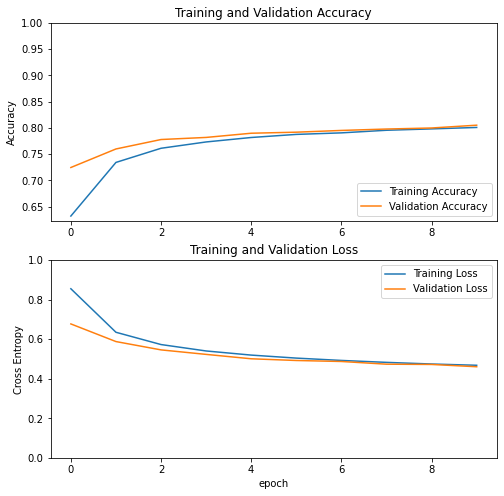

In [131]:
# graphes accuracy + loss
# si c'est pas mal on passe à la suite, sinon on refait au dessus
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

[0.00250526 0.01377668 0.4046743  0.5790437 ]
[3.3439003e-04 2.4400435e-03 6.6428798e-01 3.3293766e-01]
[0.00702408 0.02227828 0.86845875 0.10223892]
[4.4352379e-05 4.0601502e-04 6.5688878e-01 3.4266087e-01]
[6.6343771e-04 3.1732689e-03 1.5191175e-01 8.4425151e-01]
[2.6197170e-04 1.9329585e-03 3.7607774e-01 6.2172735e-01]
[0.00283504 0.0076587  0.9079297  0.08157659]
[0.00089089 0.00542997 0.5926182  0.4010609 ]
[3.7105397e-05 2.9819217e-04 4.7963969e-02 9.5170081e-01]


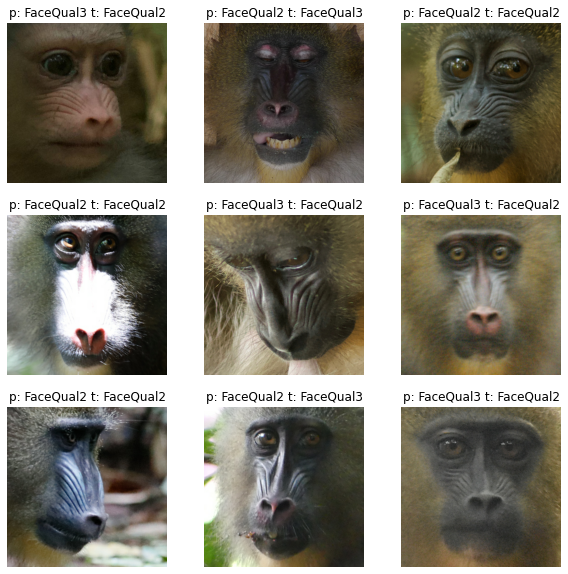

In [133]:
predictions = model.predict(test_dataset)
plt.figure(figsize=(10, 10))
for images, labels in test_dataset.take(1):
  for i in range(9):
    print(predictions[i])
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("p: " + class_names[np.argmax(predictions[i])] + " t: " + class_names[labels[i]])
    plt.axis("off")

In [77]:
#model.save('saved_model/mobilenetv2_qualite_gel')
model.save("saved_model/mobilenetv2_qualite_gel.h5")

# On fine-tune le modèle une fois qu'il a "appris au maximum"
=> unfreezing de layers supérieurs

In [134]:
base_model.trainable = True

In [135]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [136]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/10), # learning rate + faible que dans la 1re partie
              metrics=['accuracy'])

In [137]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_ds)

Epoch 10/20
468/468 [==============================] - 90s 183ms/step - loss: 0.4425 - accuracy: 0.8127 - val_loss: 0.4390 - val_accuracy: 0.8089
Epoch 11/20
468/468 [==============================] - 85s 181ms/step - loss: 0.3751 - accuracy: 0.8443 - val_loss: 0.4045 - val_accuracy: 0.8215
Epoch 12/20
468/468 [==============================] - 85s 181ms/step - loss: 0.3330 - accuracy: 0.8637 - val_loss: 0.3667 - val_accuracy: 0.8398
Epoch 13/20
468/468 [==============================] - 84s 179ms/step - loss: 0.2982 - accuracy: 0.8822 - val_loss: 0.3445 - val_accuracy: 0.8541
Epoch 14/20
468/468 [==============================] - 85s 180ms/step - loss: 0.2666 - accuracy: 0.8957 - val_loss: 0.4010 - val_accuracy: 0.8332
Epoch 15/20
468/468 [==============================] - 85s 181ms/step - loss: 0.2411 - accuracy: 0.9107 - val_loss: 0.3290 - val_accuracy: 0.8591
Epoch 16/20
468/468 [==============================] - 85s 181ms/step - loss: 0.2159 - accuracy: 0.9188 - val_loss: 0.3324 -

In [138]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

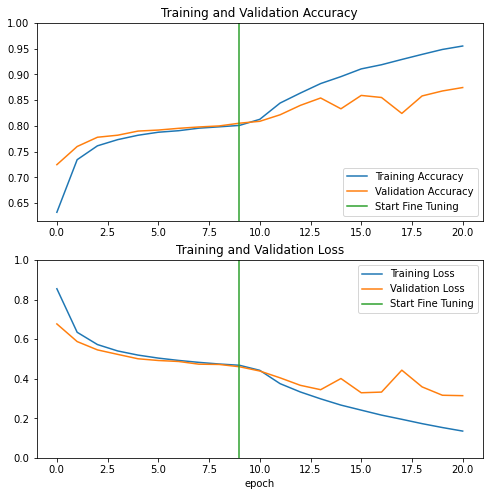

In [139]:
# graphes accuracy + loss
# si c'est pas mal on passe à la suite, sinon on refait au dessus


plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([min(plt.ylim()), 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

[1.2439877e-07 7.3543670e-06 1.4995542e-02 9.8499691e-01]
[1.1019232e-06 1.8791310e-04 8.4077710e-01 1.5903383e-01]
[1.7469141e-05 2.2714164e-02 4.1197804e-01 5.6529033e-01]
[1.2141832e-07 2.7322540e-05 8.0955333e-01 1.9041921e-01]
[5.2961976e-08 3.0588178e-06 7.8256434e-01 2.1743257e-01]
[1.4739604e-06 8.8527282e-05 1.9841297e-01 8.0149704e-01]
[2.5783624e-08 6.3200473e-06 2.9350962e-02 9.7064275e-01]
[1.4163821e-07 4.5030611e-05 9.9992096e-01 3.3903216e-05]
[1.7626498e-05 1.2965873e-02 9.6970630e-01 1.7310176e-02]
[7.0974776e-10 6.9198774e-07 4.4267114e-02 9.5573223e-01]
[7.0664616e-09 3.0510539e-06 1.4427501e-02 9.8556942e-01]
[3.8018859e-06 1.2943670e-04 5.8813144e-02 9.4105357e-01]
[6.9701974e-07 5.0378533e-04 9.9947327e-01 2.2241407e-05]
[4.9534872e-05 1.7432170e-02 9.1986006e-01 6.2658213e-02]
[1.4047297e-03 1.2455499e-01 8.7392640e-01 1.1381875e-04]
[1.07532156e-04 3.91268870e-03 9.71571326e-01 2.44083814e-02]
[6.0110499e-09 6.7347469e-07 1.6187923e-02 9.8381132e-01]
[3.1617845

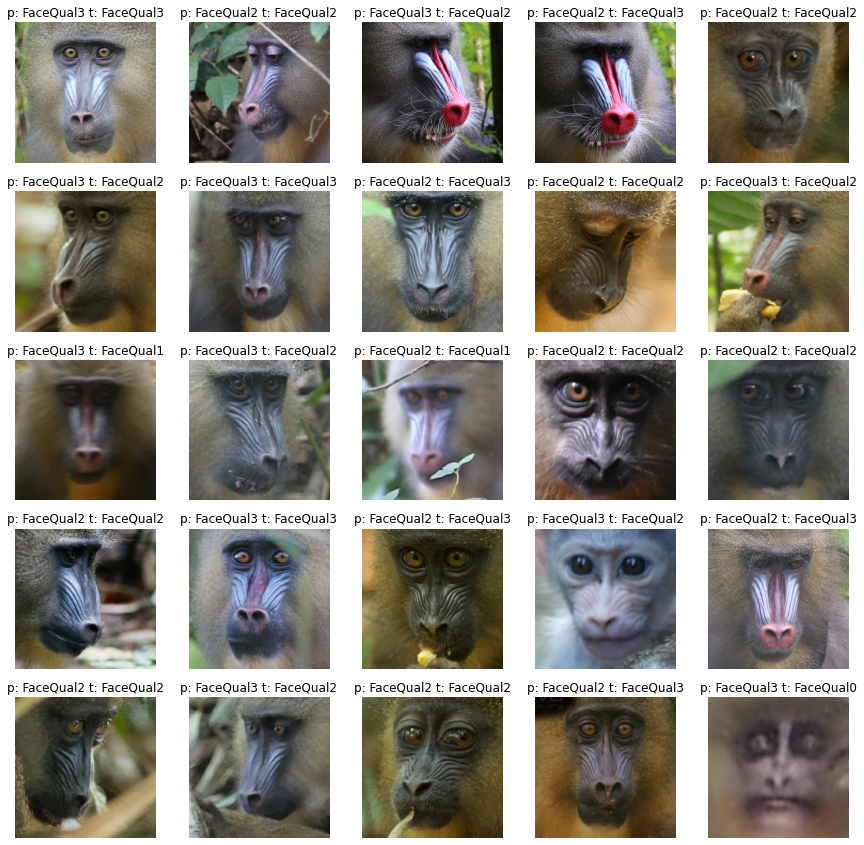

In [146]:
predictions = model.predict(test_dataset)
plt.figure(figsize=(15, 15))
for images, labels in test_dataset.take(1):
  for i in range(25):
    print(predictions[i])
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title("p: " + class_names[np.argmax(predictions[i])] + " t: " + class_names[labels[i]])
    plt.axis("off")

In [ ]:
# Classification report

# get predict prob and label
ypred = model.predict(xtrain, verbose=1)
ypred = np.argmax(ypred, axis=1)

print(classification_report(np.argmax(ytrain, axis=1), ypred, target_names=class_names))


# Matrice de confusion
cm = confusion_matrix(np.argmax(ytrain, axis=1), ypred)
cm = pandas.DataFrame(cm, range(2),range(2))
plt.figure(figsize = (10,10))

seaborn.heatmap(cm, annot=True, annot_kws={"size": 12}) # font size
plt.show()